# SASRec model

In [1]:
import pandas as pd
import numpy as np
import os
import torch
from lightning_fabric import seed_everything

from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models.sasrec import SasRecModel

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Prepare data

We are using KION dataset for this tutorial. The data was gathered from the users of MTS KION video streaming platform. To make recommendations only user-item interactions are required, as SASRec implementation does not support user and item features.

In [2]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

Archive:  data_en.zip
  inflating: data_en/items_en.csv    
  inflating: __MACOSX/data_en/._items_en.csv  
  inflating: data_en/interactions.csv  
  inflating: __MACOSX/data_en/._interactions.csv  
  inflating: data_en/users_en.csv    
  inflating: __MACOSX/data_en/._users_en.csv  
CPU times: user 119 ms, sys: 76.4 ms, total: 195 ms
Wall time: 9.43 s


In [2]:
# Read data
DATA_PATH = Path("data_en")
items_features = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)
interactions.head(3)

,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [3]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
interactions.drop(interactions.query("total_dur < 300").index, inplace=True)
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]

# drop items with less than MIN_ITEM_FREQUENCY interactions in train
MIN_ITEM_FREQUENCY = 20
items = interactions[Columns.Item].value_counts()
items = items[items >= MIN_ITEM_FREQUENCY]
interactions = interactions[interactions[Columns.Item].isin(items.index)]

SASRec filters out users with less than 2 interactions during train stage, as target is a shifted interaction sequence. However, it is still possible to make recommendations for user with one interaction in history if this interaction item was present at training.

In [4]:
# prepare test user with more than 1 interaction
test_user = np.array([11526])
print(interactions[interactions[Columns.User] == test_user[0]].shape)

interactions[interactions[Columns.User] == test_user[0]].head(2).merge(items_features[[Columns.Item, "title_orig"]], on=Columns.Item)

(440, 4)


,user_id,item_id,datetime,weight,title_orig
0,11526,14959,2021-07-12,1,Inconceivable
1,11526,6911,2021-04-01,3,Anonymes


In [5]:
# prepare test user with 1 interaction
test_user_one_interaction = np.array([324373])
print(interactions[interactions[Columns.User] == test_user_one_interaction[0]].shape)
interactions[interactions[Columns.User] == test_user_one_interaction[0]].merge(items_features[[Columns.Item, "title_orig"]], on=Columns.Item)

(1, 4)


,user_id,item_id,datetime,weight,title_orig
0,324373,10440,2021-06-24,3,Khrustal'nyy


In [6]:
# Create dataset 
dataset = Dataset.construct(
    interactions_df=interactions,
)

In [7]:
RANDOM_SEED = 32
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_SEED, workers=True)

Seed set to 32


32

# Model description

SASRec stands for a self-attention based sequential recommendation model. As the naming states, SASRec is trained on user sessions with the aim to predict next-item in the sequence. For that transformer blocks with multi-head attention are applied to capture long-term dependencies in an efficient way. 

### Preprocessing
Preprocessing steps will be shown using toy dataset:

<table>
    <tr>
        <th> user_id </th>
        <th> item_id </th>
        <th> weight </th> 
        <th> datetime </th>
    </tr>
    <tr>
        <td>u1</td>
        <td>i1</td>
        <td>0.1</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i1</td>
        <td>0.3</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i3</td>
        <td>0.2</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i2</td>
        <td>0.3</td>
        <td>2021-09-07</td>
    </tr>
        <tr>
        <td>u3</td>
        <td>i2</td>
        <td>0.4</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i3</td>
        <td>0.5</td>
        <td>2021-09-08</td>
    </tr>
</table>

1. Filter out users with less than 2 interactions in train dataset. The model uses shifted user interactions to make next item prediction, thus at least 2 items should be in the history. 

2. Leave `session_maxlen` most recent interactions for each user.

After first 2 steps, some users and/or items may be filtered out from train dataset. However, as it will be shown further, it is still possible to make recommendations for a previously unmet user, if interaction is known.

3. Create user sessions: for each user specify items with which there was an interaction in the order from earliest to most recent. Sessions for example dataset are the following:
$$S^1 = (i2, i3, i1)$$
$$S^2 = (i3, i1)$$

4. Before train stage each session is divided into train and target. As the task is to predict next item, shifted sequence is considered as target.
$$S^1_{train} = (i2, i3), S^1_{target} = (i3, i1)$$
$$S^2_{train} = (i3), S^2_{target} = (i1)$$
5. Both train and target sequences are adjusted to have user-defined `session_maxlen`:
    * If session is longer than `session_maxlen`, cut earliest items
    * If session is shorter than `session_maxlen`, pad earliest items with PAD element
$$S^1_{train} = (PAD, PAD, PAD, i2, i3), S^1_{target} = (PAD, PAD, PAD, i3, i1)$$
$$S^2_{train} = (PAD, PAD, PAD, PAD, i3), S^2_{target} = (PAD, PAD, PAD, PAD, i1)$$

### Train procedure


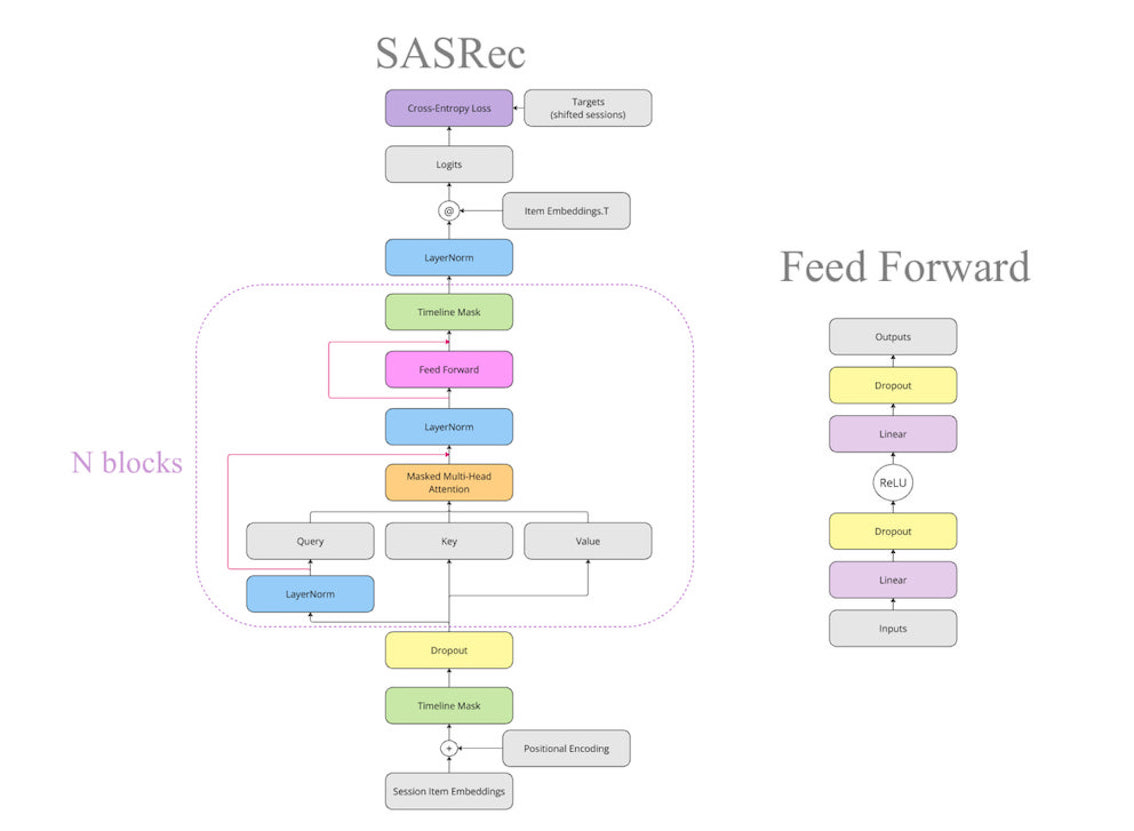

* Positional embedding is used to capture order of user-item interactions
* Timeline mask allows to mask padded items in session embeddings with 0

<b>Self-attention block structure</b>

* Multi-head attention layer receives queries after layer normalisarion, keys and values without it. Masked attention is required to forbid model consider future interactions: cannot access element t+2 when predicting element t+1. Following notation from original article: 
$$ \text{Attention}(Q, K, V) = \text{softmax} (\frac {QK^T}{\sqrt{d}})V $$
$$S = SA(\hat{E}) = \text{Attention} (\hat{E}W^Q, \hat{E}W^K, \hat{E}W^V)$$
* Point-wise feed-forward network has the following structure: $F_i = \text{FFN}(S_i) = \text{ReLU}(S_i \cdot W^{(1)} + b^{(1)}) \cdot W^{(2)} + b^{(2)}$,

where $S_i, S_j$ - items of user sequence

$W_1, W_2$ - weights

$b_1, b_2$ - biases
* To avoid overfitting and stabelize training process, 2 residual connections are applied adding data after layer normalization.

<b>Prediction</b>
* Apply LayerNorm to self-attention block output. Output represents current session embeddings
* logits = session embeddings  @  item embeddings $^T$

### Additional details
1. CrossEntropyLoss without reduction is applied. 0 index is ignored not to take into account pad element
2. Loss function output is multiplied by weight of each item in session
3. Adam optimizer with betas=(0.9, 0.98) is used
4. Xavier normal initialization for model parameters

# Recommendations

### Preprocessing
1. Filter out items from test dataset, which were not present in train dataset.
2. Leave only target users, for whom all interaction items are known from train

### Recommendation prediction
1. For each test user calculate user embeddings by passing sessions through transformer blocks and layer normalisation.
2. For each item get item embedding
3. Apply implicit ranker to make recommendations. Implicit ranker uses implicit library matrix factorization topk method that:
    * Receives item and user embeddings
    * Finds relevanace of each item by multiplication of user and item embeddings
    * Returns items within topk with greates relevance


For u2i recommendations DOT distance is applied, for i2i - COSINE

# Model Application

* Specify latent embeddings size with `n_factors`
* Specify number of self-attention blocks with `n_blocks` 
* Specify number of attention heads with `n_heads`
* Specify `dropout_rate`
* Specify whether positional encoding should be used with `use_pos_emb`
* Specify maximum length of user-item interaction history with `session_maxlen`
* Specify `lr` for learning rate 
* Specify `batch_size`
* Specify `epochs` for number of model training epochs

In [8]:
factors=128
session_maxlen=32
model = SasRecModel(
    n_factors=factors,  # 50
    n_blocks=2,
    n_heads=1,
    dropout_rate=0.2,
    use_pos_emb=True,
    session_maxlen=session_maxlen,
    lr=1e-3,
    batch_size=128,
    epochs=5,
    device="cuda:1",
    loss="softmax",
)

In [9]:
%%time
model.fit(dataset)

CPU times: user 5min 26s, sys: 7.25 s, total: 5min 34s
Wall time: 5min 30s


In [10]:
%%time
recs = model.recommend(
    users = test_user, 
    dataset = dataset,
    k = 3,
    filter_viewed = True,
)
recs.merge(items_features[["item_id", "title_orig"]], on="item_id")

100%|██████████| 1/1 [00:00<00:00, 194.68it/s]

CPU times: user 600 ms, sys: 1.1 s, total: 1.7 s
Wall time: 150 ms


,user_id,item_id,score,rank,title_orig
0,11526,9728,2.480423,1,Wrath of Man
1,11526,10440,2.229481,2,Khrustal'nyy
2,11526,5732,1.930403,3,Adore


In [11]:
%%time
recs = model.recommend(
    users = test_user_one_interaction, 
    dataset = dataset,
    k = 3,
    filter_viewed = True,
)
recs.merge(items_features[["item_id", "title_orig"]], on="item_id")

100%|██████████| 1/1 [00:00<00:00, 170.44it/s]

CPU times: user 878 ms, sys: 799 ms, total: 1.68 s
Wall time: 132 ms


,user_id,item_id,score,rank,title_orig
0,324373,15297,5.265191,1,Klinika schast'ya
1,324373,9728,3.936543,2,Wrath of Man
2,324373,13865,3.849568,3,V2. Escape from Hell


# Links

1. SASRec original paper: [Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)